In [55]:
import numpy as np
from skimage import measure
from skimage.segmentation import find_boundaries
from skimage.morphology import opening,closing
from skimage.io import imread
from matplotlib import pyplot as plt
import os
from os import listdir
import pandas as pd
from scipy.stats import kde
import seaborn as sns
import copy
from math import exp,log
import pickle
import scipy.ndimage as ndimage
import scipy.interpolate.fitpack as fitpack
from sklearn import manifold,decomposition,random_projection,cluster,metrics,preprocessing,mixture,model_selection
from sklearn.neighbors import kneighbors_graph,BallTree
from hmmlearn import hmm

import scipy.io as sio

from mpl_toolkits.mplot3d import Axes3D
from cell_class import single_cell
import contour_class
import utility_tools
import image_warp
from contour_tool import df_find_contour_points,find_contour_points,generate_contours,align_contour_to,align_contours
from scipy.signal import medfilt
from traj_class import single_cell_traj,fluor_single_cell_traj

In [56]:
main_path='a549_pcna_144h/'

output_path=main_path+'output/'
cells_path=main_path+'cells/'
# object_path=main_path+'Per_Object/'
ict_path=main_path+'intact_cycle_traj/'
if not os.path.exists(ict_path):
    os.makedirs(ict_path)

# pmid_path=main_path+'pmid_traj/'#partial mother intact daughter
# if not os.path.exists(pmid_path):
#     os.makedirs(pmid_path)

# impd_path=main_path+'impd_traj/'#intact mother partial daughter
# if not os.path.exists(impd_path):
#     os.makedirs(impd_path)    
    
# sct_path=main_path+'single_cell_traj/'
# if not os.path.exists(sct_path):
#     os.makedirs(sct_path) 

posi_end=3
traj_len_thres=80
part_traj_len_thres=30
am_range=6

In [57]:
# key_list=['Cell_AreaShape_Area', 'Cell_AreaShape_Center_X', 'Cell_AreaShape_Center_Y', 'Cell_AreaShape_Center_Z', \
#           'Cell_AreaShape_Compactness', 'Cell_AreaShape_Eccentricity', 'Cell_AreaShape_EulerNumber', \
#           'Cell_AreaShape_Extent', 'Cell_AreaShape_FormFactor', 'Cell_AreaShape_MajorAxisLength',\
#           'Cell_AreaShape_MaxFeretDiameter', 'Cell_AreaShape_MaximumRadius', 'Cell_AreaShape_MeanRadius', \
#           'Cell_AreaShape_MedianRadius', 'Cell_AreaShape_MinFeretDiameter', 'Cell_AreaShape_MinorAxisLength', \
#           'Cell_AreaShape_Orientation', 'Cell_AreaShape_Perimeter', 'Cell_AreaShape_Solidity']
# key_mask=np.ones((len(key_list),),dtype=bool)
# key_mask[key_list.index('Cell_AreaShape_Center_Y')]=False
# key_mask[key_list.index('Cell_AreaShape_Center_X')]=False
# key_mask[key_list.index('Cell_AreaShape_Center_Z')]=False
# key_mask[key_list.index('Cell_AreaShape_EulerNumber')]=False
# key_mask[key_list.index('Cell_AreaShape_Orientation')]=False


In [58]:
def consecutive_arrs(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

In [59]:
def judge_traj_am(df,am_record,traj_seri,judge_later=True,t_range=3):
    #----for mother cell, judge_later=True, because the begining need to be judged
    #---for daughter cell, judge_later=False, because the end need to be judged
    
    t_span=max(df['ImageNumber'])
    obj_am_flag=0
    if len(traj_seri)>0:
        obj_traj_label=(df.loc[(df['ImageNumber']==traj_seri[0][0])&(df['ObjectNumber']==traj_seri[0][1])]['Cell_TrackObjects_Label'].values).item()

        if judge_later==True:
            img_num,obj_num=traj_seri[0][0],traj_seri[0][1]
            ot_piece=df.loc[(df['ImageNumber']>=img_num)&(df['ImageNumber']<min(t_span,img_num+t_range))&(df['Cell_TrackObjects_Label']==obj_traj_label),['ImageNumber','ObjectNumber']].values.tolist()
        else:
            img_num,obj_num=traj_seri[-1][0],traj_seri[-1][1]
            ot_piece=df.loc[(df['ImageNumber']<=img_num)&(df['ImageNumber']>max(0,img_num-t_range))&(df['Cell_TrackObjects_Label']==obj_traj_label),['ImageNumber','ObjectNumber']].values.tolist()

        #will return the am_flag of the last time point in t_range, the last time point reflect more possible state:mitosis to apoptosis
        for ot_i_n,ot_o_n in ot_piece:
            if ((am_record['ImageNumber']==ot_i_n)&(am_record['ObjectNumber']==ot_o_n)).any():         
                obj_am_flag=(am_record.loc[(am_record['ImageNumber']==ot_i_n)&(am_record['ObjectNumber']==ot_o_n),'am_flag'].values).item()
    return obj_am_flag

In [60]:
def judge_ict(mitosis_record,traj_label):#for judging intact cell cycle traj based on mitosis record, this criteria is more strict than judge_traj_am because 
    ict_flag=0
    if traj_label==-1:
        return ict_flag
    if (mitosis_record['mother_traj_label']==traj_label).any():
        if (mitosis_record['sis1_traj_label']==traj_label).any() or (mitosis_record['sis2_traj_label']==traj_label).any():
            ict_flag=1
    return ict_flag


In [64]:
def generate_single_cell_traj(traj_label,df,cells,traj_df,fluor_name,fluor_feature_name,pc_num):
    time_span=max(df['ImageNumber'])
    traj_record=pd.DataFrame(traj_df.loc[:,'1':str(time_span)])
    traj_record=traj_record.values
    traj_quan,traj_len=traj_record.shape[0],traj_record.shape[1]
    
    traj_xy=[]
    traj_feature=[]
    traj_contour=[]
    traj_cord=[]
    traj_seri=[]
    traj_am_flag=[]
 
    traj_fluor_feature_values=[]
    traj_haralick=[]
    traj_norm_haralick=[]
    traj_fluor_pca_cord=[]
#     traj_norm_fluor_pca_cord=[]
    
    for img_num in range(1,traj_len+1):
        obj_num=(traj_df.loc[traj_df['traj_label']==traj_label,str(img_num)].values).item()
        if obj_num!=-1:
            ind=df.loc[(df['ImageNumber']==img_num)&(df['ObjectNumber']==obj_num)].index.tolist()[0]
#             print(dir(cells[ind]))
            if hasattr(cells[ind],'cell_contour')and hasattr(cells[ind],'pca_cord'):
                traj_contour.append(cells[ind].cell_contour.points.flatten())
                traj_cord.append(cells[ind].pca_cord)
                traj_seri.append([img_num,obj_num])
                if ((am_record['ImageNumber']==img_num)&(am_record['ObjectNumber']==obj_num)).any():
                    am_flag=(am_record.loc[(am_record['ImageNumber']==img_num)&(am_record['ObjectNumber']==obj_num),'am_flag'].values).item()
                    traj_am_flag.append(am_flag)
                else:
                    traj_am_flag.append(0)
                
                if hasattr(cells[ind],fluor_name+'_feature_values'):
#                     print(cells[ind].vimentin_haralick_pca_cord)
                    exec('traj_fluor_feature_values.append(np.array(cells[ind].'+fluor_name+'_feature_values[:3]))')
                    exec('traj_haralick.append(np.array(cells[ind].'+fluor_name+'_feature_values[3]))')
                    exec('traj_norm_haralick.append(np.array(cells[ind].'+fluor_name+'_feature_values[4]))')
                    exec('traj_fluor_pca_cord.append(cells[ind].'+fluor_feature_name[0]+'_pca_cord)')
#                     exec('traj_norm_fluor_pca_cord.append(cells[ind].'+fluor_feature_name[1]+'_pca_cord)')
                else:                    
                    traj_fluor_feature_values.append(np.zeros((3,)))
                    traj_haralick.append((np.zeros(13,)))
                    traj_norm_haralick.append((np.zeros(13,)))
                    traj_fluor_pca_cord.append(np.zeros((pc_num,)))
#                     traj_norm_fluor_pca_cord.append(np.zeros((6,)))
#                     

    traj_xy=np.asarray(traj_xy)
    traj_feature=np.asarray(traj_feature)
    traj_contour=np.asarray(traj_contour)
    print(traj_xy.shape)

    traj_cord=np.asarray(traj_cord)
    traj_seri=np.asarray(traj_seri)
    
    traj_am_flag=np.asarray(traj_am_flag)
    
    traj_fluor_feature_values=np.asarray(traj_fluor_feature_values)
    print(traj_fluor_feature_values.shape)
    
    traj_haralick=np.asarray(traj_haralick)

    traj_norm_haralick=np.asarray(traj_norm_haralick)
#     print(traj_fluor_pca_cord)
    traj_fluor_pca_cord=np.asarray(traj_fluor_pca_cord)
    
#     traj_norm_fluor_pca_cord=np.asarray(traj_norm_fluor_pca_cord)

#     mask=traj_fluor_feature_values[:,0]!=0
#     dot_color=np.arange(traj_cord[mask].shape[0])
#     cm=plt.cm.get_cmap('jet')

#     sc=plt.scatter(traj_cord[mask][:,0],traj_fluor_pca_cord[mask][:,0],s=8,c=dot_color,cmap=cm)
#     plt.xlabel('PC1',fontsize=16)
#     plt.ylabel('haralickPC1',fontsize=16)
#     #     plt.axis([-450,800,-400,400])
#     plt.colorbar(sc)
#     plt.show()
    return traj_feature,traj_contour,traj_cord,traj_seri,traj_am_flag,\
       [traj_fluor_feature_values[:,0],traj_fluor_feature_values[:,1],traj_fluor_feature_values[:,2],\
       traj_haralick,traj_norm_haralick],traj_fluor_pca_cord
    

        

1
4.0
(0,)
(7, 3)
(0,)
(7, 3)
15.0
(0,)
(159, 3)
(0,)
(159, 3)
16.0
(0,)
(1, 3)
(0,)
(1, 3)
11.0
(0,)
(56, 3)
(0,)
(56, 3)
37.0
(0,)
(8, 3)
(0,)
(8, 3)
38.0
(0,)
(7, 3)
(0,)
(7, 3)
17.0
(0,)
(45, 3)
(0,)
(45, 3)
39.0
(0,)
(34, 3)
(0,)
(34, 3)
40.0
(0,)
(219, 3)
(0,)
(219, 3)


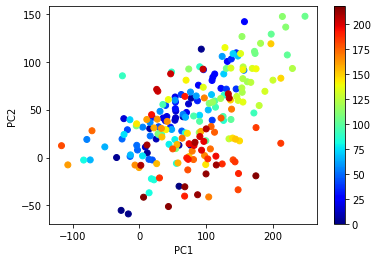

13.0
(0,)
(77, 3)
(0,)
(77, 3)
48.0
(0,)
(95, 3)
(0,)
(95, 3)
49.0
(0,)
(193, 3)
(0,)
(193, 3)
12.0
(0,)
(93, 3)
(0,)
(93, 3)
58.0
(0,)
(10, 3)
(0,)
(10, 3)
57.0
(0,)
(2, 3)
(0,)
(2, 3)
21.0
(0,)
(84, 3)
(0,)
(84, 3)
64.0
(0,)
(127, 3)
(0,)
(127, 3)
63.0
(0,)
(23, 3)
(0,)
(23, 3)
71.0
(0,)
(10, 3)
(0,)
(10, 3)
79.0
(0,)
(6, 3)
(0,)
(6, 3)
80.0
(0,)
(3, 3)
(0,)
(3, 3)
7.0
(0,)
(178, 3)
(0,)
(178, 3)
100.0
(0,)
(19, 3)
(0,)
(19, 3)
101.0
(0,)
(88, 3)
(0,)
(88, 3)
111.0
(0,)
(19, 3)
(0,)
(19, 3)
120.0
(0,)
(85, 3)
(0,)
(85, 3)
121.0
(0,)
(5, 3)
(0,)
(5, 3)
40.0
(0,)
(219, 3)
(0,)
(219, 3)


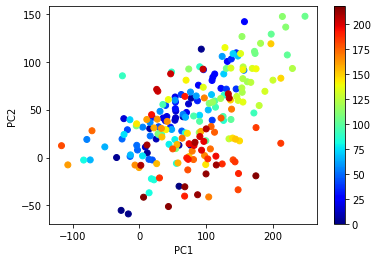

176.0
(0,)
(50, 3)
(0,)
(50, 3)
177.0
(0,)
(1, 3)
(0,)
(1, 3)
187.0
(0,)
(7, 3)
(0,)
(7, 3)
195.0
(0,)
(12, 3)
(0,)
(12, 3)
196.0
(0,)
(6, 3)
(0,)
(6, 3)
51.0
(0,)
(252, 3)
(0,)
(252, 3)
211.0
(0,)
(12, 3)
(0,)
(12, 3)
213.0
(0,)
(27, 3)
(0,)
(27, 3)
217.0
(0,)
(10, 3)
(0,)
(10, 3)
226.0
(0,)
(7, 3)
(0,)
(7, 3)
225.0
(0,)
(8, 3)
(0,)
(8, 3)
231.0
(0,)
(13, 3)
(0,)
(13, 3)
245.0
(0,)
(3, 3)
(0,)
(3, 3)
247.0
(0,)
(1, 3)
(0,)
(1, 3)
229.0
(0,)
(13, 3)
(0,)
(13, 3)
246.0
(0,)
(18, 3)
(0,)
(18, 3)
248.0
(0,)
(2, 3)
(0,)
(2, 3)
309.0
(0,)
(1, 3)
(0,)
(1, 3)
312.0
(0,)
(4, 3)
(0,)
(4, 3)
310.0
(0,)
(25, 3)
(0,)
(25, 3)
327.0
(0,)
(2, 3)
(0,)
(2, 3)
332.0
(0,)
(2, 3)
(0,)
(2, 3)
331.0
(0,)
(22, 3)
(0,)
(22, 3)
314.0
(0,)
(11, 3)
(0,)
(11, 3)
340.0
(0,)
(2, 3)
(0,)
(2, 3)
339.0
(0,)
(46, 3)
(0,)
(46, 3)
207.0
(0,)
(96, 3)
(0,)
(96, 3)
351.0
(0,)
(1, 3)
(0,)
(1, 3)
352.0
(0,)
(1, 3)
(0,)
(1, 3)
395.0
(0,)
(1, 3)
(0,)
(1, 3)
399.0
(0,)
(6, 3)
(0,)
(6, 3)
396.0
(0,)
(7, 3)
(0,)
(7, 3)
275.0
(0,)


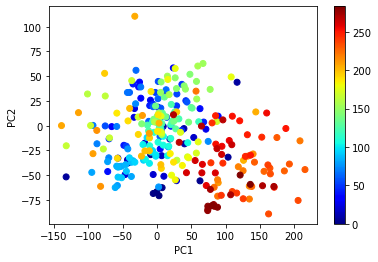

511.0
(0,)
(53, 3)
(0,)
(53, 3)
608.0
(0,)
(25, 3)
(0,)
(25, 3)
609.0
(0,)
(53, 3)
(0,)
(53, 3)
606.0
(0,)
(22, 3)
(0,)
(22, 3)
647.0
(0,)
(1, 3)
(0,)
(1, 3)
646.0
(0,)
(13, 3)
(0,)
(13, 3)
573.0
(0,)
(45, 3)
(0,)
(45, 3)
664.0
(0,)
(18, 3)
(0,)
(18, 3)
665.0
(0,)
(424, 3)
(0,)
(424, 3)
673.0
(0,)
(7, 3)
(0,)
(7, 3)
680.0
(0,)
(2, 3)
(0,)
(2, 3)
681.0
(0,)
(39, 3)
(0,)
(39, 3)
432.0
(0,)
(153, 3)
(0,)
(153, 3)
726.0
(0,)
(3, 3)
(0,)
(3, 3)
723.0
(0,)
(33, 3)
(0,)
(33, 3)
618.0
(0,)
(72, 3)
(0,)
(72, 3)
740.0
(0,)
(12, 3)
(0,)
(12, 3)
739.0
(0,)
(18, 3)
(0,)
(18, 3)
528.0
(0,)
(134, 3)
(0,)
(134, 3)


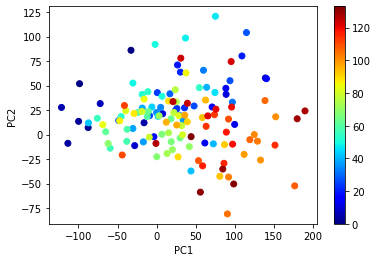

750.0
(0,)
(1, 3)
(0,)
(1, 3)
751.0
(0,)
(73, 3)
(0,)
(73, 3)
699.0
(0,)
(42, 3)
(0,)
(42, 3)
763.0
(0,)
(1, 3)
(0,)
(1, 3)
767.0
(0,)
(20, 3)
(0,)
(20, 3)
698.0
(0,)
(48, 3)
(0,)
(48, 3)
776.0
(0,)
(5, 3)
(0,)
(5, 3)
775.0
(0,)
(8, 3)
(0,)
(8, 3)
358.0
(0,)
(266, 3)
(0,)
(266, 3)
808.0
(0,)
(19, 3)
(0,)
(19, 3)
805.0
(0,)
(18, 3)
(0,)
(18, 3)
741.0
(0,)
(49, 3)
(0,)
(49, 3)
834.0
(0,)
(118, 3)
(0,)
(118, 3)
833.0
(0,)
(5, 3)
(0,)
(5, 3)
855.0
(0,)
(1, 3)
(0,)
(1, 3)
858.0
(0,)
(17, 3)
(0,)
(17, 3)
857.0
(0,)
(29, 3)
(0,)
(29, 3)
820.0
(0,)
(14, 3)
(0,)
(14, 3)
865.0
(0,)
(8, 3)
(0,)
(8, 3)
864.0
(0,)
(18, 3)
(0,)
(18, 3)
480.0
(0,)
(220, 3)
(0,)
(220, 3)
896.0
(0,)
(2, 3)
(0,)
(2, 3)
894.0
(0,)
(6, 3)
(0,)
(6, 3)
367.0
(0,)
(301, 3)
(0,)
(301, 3)


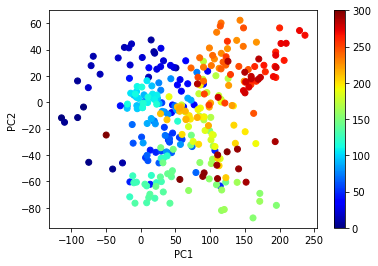

909.0
(0,)
(1, 3)
(0,)
(1, 3)
907.0
(0,)
(46, 3)
(0,)
(46, 3)
893.0
(0,)
(7, 3)
(0,)
(7, 3)
917.0
(0,)
(27, 3)
(0,)
(27, 3)
916.0
(0,)
(41, 3)
(0,)
(41, 3)
831.0
(0,)
(59, 3)
(0,)
(59, 3)
971.0
(0,)
(8, 3)
(0,)
(8, 3)
972.0
(0,)
(5, 3)
(0,)
(5, 3)
971.0
(0,)
(8, 3)
(0,)
(8, 3)
1031.0
(0,)
(22, 3)
(0,)
(22, 3)
1027.0
(0,)
(7, 3)
(0,)
(7, 3)
1078.0
(0,)
(22, 3)
(0,)
(22, 3)
1124.0
(0,)
(6, 3)
(0,)
(6, 3)
1123.0
(0,)
(16, 3)
(0,)
(16, 3)
582.0
(0,)
(284, 3)
(0,)
(284, 3)


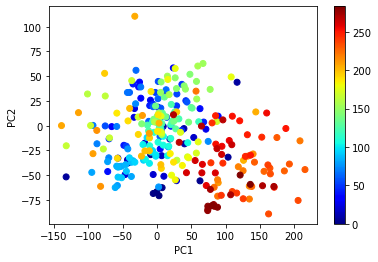

1160.0
(0,)
(309, 3)
(0,)
(309, 3)
1159.0
(0,)
(7, 3)
(0,)
(7, 3)
1128.0
(0,)
(16, 3)
(0,)
(16, 3)
1193.0
(0,)
(7, 3)
(0,)
(7, 3)
1192.0
(0,)
(15, 3)
(0,)
(15, 3)
1145.0
(0,)
(16, 3)
(0,)
(16, 3)
1205.0
(0,)
(3, 3)
(0,)
(3, 3)
1206.0
(0,)
(21, 3)
(0,)
(21, 3)
1184.0
(0,)
(10, 3)
(0,)
(10, 3)
1214.0
(0,)
(25, 3)
(0,)
(25, 3)
1213.0
(0,)
(4, 3)
(0,)
(4, 3)
1222.0
(0,)
(10, 3)
(0,)
(10, 3)
1242.0
(0,)
(4, 3)
(0,)
(4, 3)
1244.0
(0,)
(30, 3)
(0,)
(30, 3)
846.0
(0,)
(163, 3)
(0,)
(163, 3)
1246.0
(0,)
(3, 3)
(0,)
(3, 3)
1250.0
(0,)
(3, 3)
(0,)
(3, 3)
1227.0
(0,)
(10, 3)
(0,)
(10, 3)
1257.0
(0,)
(2, 3)
(0,)
(2, 3)
1256.0
(0,)
(3, 3)
(0,)
(3, 3)
1239.0
(0,)
(8, 3)
(0,)
(8, 3)
1263.0
(0,)
(2, 3)
(0,)
(2, 3)
1264.0
(0,)
(2, 3)
(0,)
(2, 3)
1186.0
(0,)
(49, 3)
(0,)
(49, 3)
1317.0
(0,)
(2, 3)
(0,)
(2, 3)
1315.0
(0,)
(4, 3)
(0,)
(4, 3)
1317.0
(0,)
(2, 3)
(0,)
(2, 3)
1324.0
(0,)
(1, 3)
(0,)
(1, 3)
1322.0
(0,)
(2, 3)
(0,)
(2, 3)
715.0
(0,)
(293, 3)
(0,)
(293, 3)
1370.0
(0,)
(129, 3)
(0,)
(129, 3)
1367.

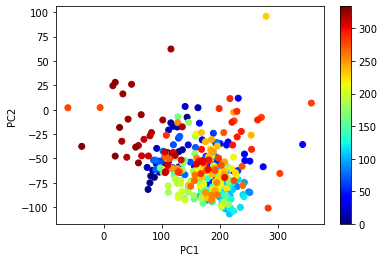

1341.0
(0,)
(85, 3)
(0,)
(85, 3)
1595.0
(0,)
(4, 3)
(0,)
(4, 3)
1594.0
(0,)
(23, 3)
(0,)
(23, 3)
1579.0
(0,)
(6, 3)
(0,)
(6, 3)
1599.0
(0,)
(4, 3)
(0,)
(4, 3)
1603.0
(0,)
(5, 3)
(0,)
(5, 3)
1630.0
(0,)
(11, 3)
(0,)
(11, 3)
1664.0
(0,)
(6, 3)
(0,)
(6, 3)
1667.0
(0,)
(2, 3)
(0,)
(2, 3)
1606.0
(0,)
(15, 3)
(0,)
(15, 3)
1662.0
(0,)
(6, 3)
(0,)
(6, 3)
1666.0
(0,)
(15, 3)
(0,)
(15, 3)
1548.0
(0,)
(32, 3)
(0,)
(32, 3)
1687.0
(0,)
(19, 3)
(0,)
(19, 3)
1686.0
(0,)
(205, 3)
(0,)
(205, 3)
1690.0
(0,)
(21, 3)
(0,)
(21, 3)
1789.0
(0,)
(3, 3)
(0,)
(3, 3)
1792.0
(0,)
(7, 3)
(0,)
(7, 3)
1790.0
(0,)
(10, 3)
(0,)
(10, 3)
1831.0
(0,)
(9, 3)
(0,)
(9, 3)
1828.0
(0,)
(3, 3)
(0,)
(3, 3)
1864.0
(0,)
(4, 3)
(0,)
(4, 3)
1881.0
(0,)
(77, 3)
(0,)
(77, 3)
1878.0
(0,)
(79, 3)
(0,)
(79, 3)
1097.0
(0,)
(298, 3)
(0,)
(298, 3)
2014.0
(0,)
(1, 3)
(0,)
(1, 3)
2018.0
(0,)
(201, 3)
(0,)
(201, 3)
1917.0
(0,)
(60, 3)
(0,)
(60, 3)
2142.0
(0,)
(21, 3)
(0,)
(21, 3)
2141.0
(0,)
(34, 3)
(0,)
(34, 3)
1888.0
(0,)
(73, 3)
(0,)
(73, 

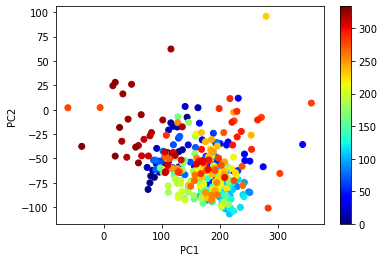

2674.0
(0,)
(1, 3)
(0,)
(1, 3)
2675.0
(0,)
(136, 3)
(0,)
(136, 3)
2788.0
(0,)
(6, 3)
(0,)
(6, 3)
2818.0
(0,)
(2, 3)
(0,)
(2, 3)
2816.0
(0,)
(5, 3)
(0,)
(5, 3)
2731.0
(0,)
(11, 3)
(0,)
(11, 3)
3019.0
(0,)
(3, 3)
(0,)
(3, 3)
3014.0
(0,)
(12, 3)
(0,)
(12, 3)
2969.0
(0,)
(11, 3)
(0,)
(11, 3)
3038.0
(0,)
(64, 3)
(0,)
(64, 3)
3035.0
(0,)
(3, 3)
(0,)
(3, 3)
2769.0
(0,)
(59, 3)
(0,)
(59, 3)
3045.0
(0,)
(22, 3)
(0,)
(22, 3)
3043.0
(0,)
(30, 3)
(0,)
(30, 3)
3014.0
(0,)
(12, 3)
(0,)
(12, 3)
3068.0
(0,)
(1, 3)
(0,)
(1, 3)
3067.0
(0,)
(79, 3)
(0,)
(79, 3)
2346.0
(0,)
(190, 3)
(0,)
(190, 3)
3103.0
(0,)
(4, 3)
(0,)
(4, 3)
3107.0
(0,)
(11, 3)
(0,)
(11, 3)
3002.0
(0,)
(28, 3)
(0,)
(28, 3)
3140.0
(0,)
(7, 3)
(0,)
(7, 3)
3138.0
(0,)
(17, 3)
(0,)
(17, 3)
3048.0
(0,)
(18, 3)
(0,)
(18, 3)
3155.0
(0,)
(19, 3)
(0,)
(19, 3)
3154.0
(0,)
(3, 3)
(0,)
(3, 3)
3079.0
(0,)
(15, 3)
(0,)
(15, 3)
3167.0
(0,)
(22, 3)
(0,)
(22, 3)
3166.0
(0,)
(11, 3)
(0,)
(11, 3)
3147.0
(0,)
(6, 3)
(0,)
(6, 3)
3194.0
(0,)
(3, 3)
(0,)
(3, 

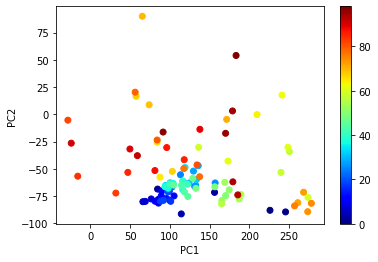

4107.0
(0,)
(31, 3)
(0,)
(31, 3)
4108.0
(0,)
(16, 3)
(0,)
(16, 3)
4037.0
(0,)
(22, 3)
(0,)
(22, 3)
4159.0
(0,)
(1, 3)
(0,)
(1, 3)
4161.0
(0,)
(3, 3)
(0,)
(3, 3)
4161.0
(0,)
(3, 3)
(0,)
(3, 3)
4176.0
(0,)
(2, 3)
(0,)
(2, 3)
4175.0
(0,)
(17, 3)
(0,)
(17, 3)
3008.0
(0,)
(263, 3)
(0,)
(263, 3)
4280.0
(0,)
(1, 3)
(0,)
(1, 3)
4278.0
(0,)
(1, 3)
(0,)
(1, 3)
2
33.0
(0,)
(27, 3)
(0,)
(27, 3)
55.0
(0,)
(4, 3)
(0,)
(4, 3)
54.0
(0,)
(2, 3)
(0,)
(2, 3)
17.0
(0,)
(62, 3)
(0,)
(62, 3)
75.0
(0,)
(34, 3)
(0,)
(34, 3)
73.0
(0,)
(114, 3)
(0,)
(114, 3)


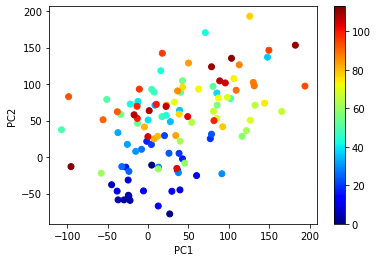

1.0
(0,)
(66, 3)
(0,)
(66, 3)
77.0
(0,)
(6, 3)
(0,)
(6, 3)
76.0
(0,)
(149, 3)
(0,)
(149, 3)
6.0
(0,)
(79, 3)
(0,)
(79, 3)
86.0
(0,)
(360, 3)
(0,)
(360, 3)
87.0
(0,)
(3, 3)
(0,)
(3, 3)
94.0
(0,)
(3, 3)
(0,)
(3, 3)
95.0
(0,)
(75, 3)
(0,)
(75, 3)
96.0
(0,)
(14, 3)
(0,)
(14, 3)
68.0
(0,)
(36, 3)
(0,)
(36, 3)
110.0
(0,)
(40, 3)
(0,)
(40, 3)
109.0
(0,)
(29, 3)
(0,)
(29, 3)
9.0
(0,)
(111, 3)
(0,)
(111, 3)
118.0
(0,)
(2, 3)
(0,)
(2, 3)
119.0
(0,)
(2, 3)
(0,)
(2, 3)
142.0
(0,)
(6, 3)
(0,)
(6, 3)
146.0
(0,)
(2, 3)
(0,)
(2, 3)
145.0
(0,)
(1, 3)
(0,)
(1, 3)
102.0
(0,)
(53, 3)
(0,)
(53, 3)
160.0
(0,)
(208, 3)
(0,)
(208, 3)


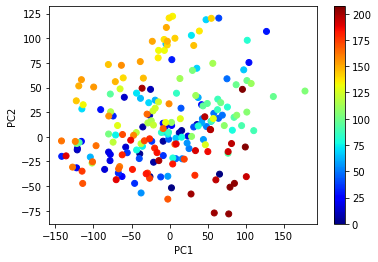

162.0
(0,)
(26, 3)
(0,)
(26, 3)
158.0
(0,)
(20, 3)
(0,)
(20, 3)
180.0
(0,)
(2, 3)
(0,)
(2, 3)
179.0
(0,)
(92, 3)
(0,)
(92, 3)
73.0
(0,)
(114, 3)
(0,)
(114, 3)


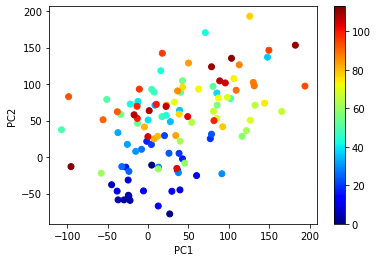

184.0
(0,)
(4, 3)
(0,)
(4, 3)
185.0
(0,)
(44, 3)
(0,)
(44, 3)
185.0
(0,)
(44, 3)
(0,)
(44, 3)
238.0
(0,)
(7, 3)
(0,)
(7, 3)
237.0
(0,)
(20, 3)
(0,)
(20, 3)
32.0
(0,)
(223, 3)
(0,)
(223, 3)
258.0
(0,)
(16, 3)
(0,)
(16, 3)
256.0
(0,)
(3, 3)
(0,)
(3, 3)
182.0
(0,)
(55, 3)
(0,)
(55, 3)
257.0
(0,)
(145, 3)
(0,)
(145, 3)
255.0
(0,)
(3, 3)
(0,)
(3, 3)
213.0
(0,)
(30, 3)
(0,)
(30, 3)
264.0
(0,)
(67, 3)
(0,)
(67, 3)
263.0
(0,)
(4, 3)
(0,)
(4, 3)
280.0
(0,)
(6, 3)
(0,)
(6, 3)
291.0
(0,)
(7, 3)
(0,)
(7, 3)
290.0
(0,)
(99, 3)
(0,)
(99, 3)
293.0
(0,)
(1, 3)
(0,)
(1, 3)
295.0
(0,)
(9, 3)
(0,)
(9, 3)
296.0
(0,)
(7, 3)
(0,)
(7, 3)
295.0
(0,)
(9, 3)
(0,)
(9, 3)
320.0
(0,)
(8, 3)
(0,)
(8, 3)
319.0
(0,)
(13, 3)
(0,)
(13, 3)
338.0
(0,)
(41, 3)
(0,)
(41, 3)
401.0
(0,)
(63, 3)
(0,)
(63, 3)
399.0
(0,)
(2, 3)
(0,)
(2, 3)
430.0
(0,)
(10, 3)
(0,)
(10, 3)
443.0
(0,)
(3, 3)
(0,)
(3, 3)
444.0
(0,)
(4, 3)
(0,)
(4, 3)
433.0
(0,)
(11, 3)
(0,)
(11, 3)
457.0
(0,)
(12, 3)
(0,)
(12, 3)
456.0
(0,)
(21, 3)
(0,)
(21, 3)
229

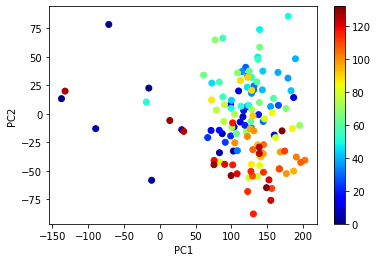

463.0
(0,)
(2, 3)
(0,)
(2, 3)
462.0
(0,)
(292, 3)
(0,)
(292, 3)
325.0
(0,)
(100, 3)
(0,)
(100, 3)
487.0
(0,)
(19, 3)
(0,)
(19, 3)
482.0
(0,)
(10, 3)
(0,)
(10, 3)
160.0
(0,)
(208, 3)
(0,)
(208, 3)


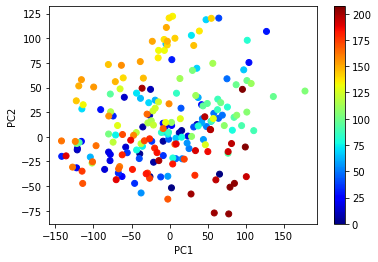

505.0
(0,)
(9, 3)
(0,)
(9, 3)
507.0
(0,)
(4, 3)
(0,)
(4, 3)
438.0
(0,)
(22, 3)
(0,)
(22, 3)
506.0
(0,)
(1, 3)
(0,)
(1, 3)
508.0
(0,)
(30, 3)
(0,)
(30, 3)
328.0
(0,)
(113, 3)
(0,)
(113, 3)
551.0
(0,)
(1, 3)
(0,)
(1, 3)
549.0
(0,)
(3, 3)
(0,)
(3, 3)
601.0
(0,)
(9, 3)
(0,)
(9, 3)
620.0
(0,)
(3, 3)
(0,)
(3, 3)
619.0
(0,)
(3, 3)
(0,)
(3, 3)
612.0
(0,)
(8, 3)
(0,)
(8, 3)
630.0
(0,)
(3, 3)
(0,)
(3, 3)
631.0
(0,)
(3, 3)
(0,)
(3, 3)
641.0
(0,)
(16, 3)
(0,)
(16, 3)
691.0
(0,)
(4, 3)
(0,)
(4, 3)
693.0
(0,)
(2, 3)
(0,)
(2, 3)
400.0
(0,)
(135, 3)
(0,)
(135, 3)
767.0
(0,)
(2, 3)
(0,)
(2, 3)
768.0
(0,)
(3, 3)
(0,)
(3, 3)
642.0
(0,)
(43, 3)
(0,)
(43, 3)
775.0
(0,)
(4, 3)
(0,)
(4, 3)
774.0
(0,)
(4, 3)
(0,)
(4, 3)
703.0
(0,)
(39, 3)
(0,)
(39, 3)
806.0
(0,)
(12, 3)
(0,)
(12, 3)
804.0
(0,)
(1, 3)
(0,)
(1, 3)
602.0
(0,)
(80, 3)
(0,)
(80, 3)
839.0
(0,)
(3, 3)
(0,)
(3, 3)
840.0
(0,)
(3, 3)
(0,)
(3, 3)
764.0
(0,)
(26, 3)
(0,)
(26, 3)
856.0
(0,)
(5, 3)
(0,)
(5, 3)
852.0
(0,)
(4, 3)
(0,)
(4, 3)
773.0
(0,)
(34, 

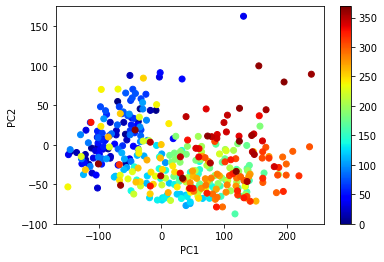

1399.0
(0,)
(76, 3)
(0,)
(76, 3)
1718.0
(0,)
(19, 3)
(0,)
(19, 3)
1717.0
(0,)
(5, 3)
(0,)
(5, 3)
1716.0
(0,)
(4, 3)
(0,)
(4, 3)
1730.0
(0,)
(1, 3)
(0,)
(1, 3)
1729.0
(0,)
(147, 3)
(0,)
(147, 3)
1330.0
(0,)
(103, 3)
(0,)
(103, 3)
1745.0
(0,)
(1, 3)
(0,)
(1, 3)
1744.0
(0,)
(5, 3)
(0,)
(5, 3)
1821.0
(0,)
(26, 3)
(0,)
(26, 3)
1955.0
(0,)
(32, 3)
(0,)
(32, 3)
1959.0
(0,)
(3, 3)
(0,)
(3, 3)
1883.0
(0,)
(53, 3)
(0,)
(53, 3)
2112.0
(0,)
(8, 3)
(0,)
(8, 3)
2113.0
(0,)
(46, 3)
(0,)
(46, 3)
2005.0
(0,)
(30, 3)
(0,)
(30, 3)
2118.0
(0,)
(3, 3)
(0,)
(3, 3)
2120.0
(0,)
(2, 3)
(0,)
(2, 3)
1596.0
(0,)
(138, 3)
(0,)
(138, 3)
2172.0
(0,)
(2, 3)
(0,)
(2, 3)
2174.0
(0,)
(4, 3)
(0,)
(4, 3)
1344.0
(0,)
(195, 3)
(0,)
(195, 3)
2179.0
(0,)
(3, 3)
(0,)
(3, 3)
2173.0
(0,)
(5, 3)
(0,)
(5, 3)
1950.0
(0,)
(53, 3)
(0,)
(53, 3)
2177.0
(0,)
(3, 3)
(0,)
(3, 3)
2176.0
(0,)
(57, 3)
(0,)
(57, 3)
2055.0
(0,)
(22, 3)
(0,)
(22, 3)
2188.0
(0,)
(299, 3)
(0,)
(299, 3)


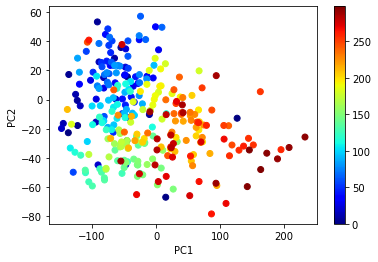

2189.0
(0,)
(11, 3)
(0,)
(11, 3)
2174.0
(0,)
(4, 3)
(0,)
(4, 3)
2204.0
(0,)
(58, 3)
(0,)
(58, 3)
2200.0
(0,)
(8, 3)
(0,)
(8, 3)
1889.0
(0,)
(72, 3)
(0,)
(72, 3)
2209.0
(0,)
(25, 3)
(0,)
(25, 3)
2211.0
(0,)
(12, 3)
(0,)
(12, 3)
1862.0
(0,)
(79, 3)
(0,)
(79, 3)
2298.0
(0,)
(1, 3)
(0,)
(1, 3)
2300.0
(0,)
(2, 3)
(0,)
(2, 3)
2300.0
(0,)
(2, 3)
(0,)
(2, 3)
2308.0
(0,)
(7, 3)
(0,)
(7, 3)
2307.0
(0,)
(6, 3)
(0,)
(6, 3)
2187.0
(0,)
(24, 3)
(0,)
(24, 3)
2313.0
(0,)
(9, 3)
(0,)
(9, 3)
2312.0
(0,)
(9, 3)
(0,)
(9, 3)
2293.0
(0,)
(11, 3)
(0,)
(11, 3)
2341.0
(0,)
(4, 3)
(0,)
(4, 3)
2340.0
(0,)
(3, 3)
(0,)
(3, 3)
1899.0
(0,)
(111, 3)
(0,)
(111, 3)
2367.0
(0,)
(9, 3)
(0,)
(9, 3)
2376.0
(0,)
(41, 3)
(0,)
(41, 3)
2411.0
(0,)
(5, 3)
(0,)
(5, 3)
2438.0
(0,)
(9, 3)
(0,)
(9, 3)
2437.0
(0,)
(1, 3)
(0,)
(1, 3)
2155.0
(0,)
(59, 3)
(0,)
(59, 3)
2455.0
(0,)
(13, 3)
(0,)
(13, 3)
2454.0
(0,)
(19, 3)
(0,)
(19, 3)
2042.0
(0,)
(87, 3)
(0,)
(87, 3)
2456.0
(0,)
(3, 3)
(0,)
(3, 3)
2453.0
(0,)
(79, 3)
(0,)
(79, 3)
1887.0


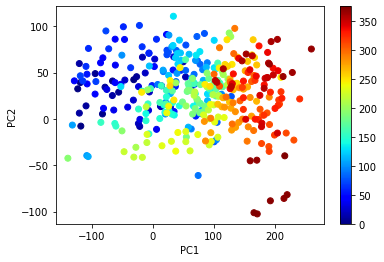

3556.0
(0,)
(24, 3)
(0,)
(24, 3)
3560.0
(0,)
(75, 3)
(0,)
(75, 3)
3446.0
(0,)
(18, 3)
(0,)
(18, 3)
3580.0
(0,)
(73, 3)
(0,)
(73, 3)
3576.0
(0,)
(38, 3)
(0,)
(38, 3)
3306.0
(0,)
(36, 3)
(0,)
(36, 3)
3592.0
(0,)
(33, 3)
(0,)
(33, 3)
3593.0
(0,)
(12, 3)
(0,)
(12, 3)
2146.0
(0,)
(252, 3)
(0,)
(252, 3)
3590.0
(0,)
(2, 3)
(0,)
(2, 3)
3591.0
(0,)
(17, 3)
(0,)
(17, 3)
3526.0
(0,)
(11, 3)
(0,)
(11, 3)
3638.0
(0,)
(1, 3)
(0,)
(1, 3)
3637.0
(0,)
(12, 3)
(0,)
(12, 3)
3595.0
(0,)
(6, 3)
(0,)
(6, 3)
3646.0
(0,)
(3, 3)
(0,)
(3, 3)
3654.0
(0,)
(31, 3)
(0,)
(31, 3)
2528.0
(0,)
(209, 3)
(0,)
(209, 3)
3672.0
(0,)
(2, 3)
(0,)
(2, 3)
3678.0
(0,)
(83, 3)
(0,)
(83, 3)
3238.0
(0,)
(64, 3)
(0,)
(64, 3)
3675.0
(0,)
(41, 3)
(0,)
(41, 3)
3677.0
(0,)
(9, 3)
(0,)
(9, 3)
3542.0
(0,)
(15, 3)
(0,)
(15, 3)
3698.0
(0,)
(21, 3)
(0,)
(21, 3)
3696.0
(0,)
(4, 3)
(0,)
(4, 3)
3571.0
(0,)
(17, 3)
(0,)
(17, 3)
3712.0
(0,)
(43, 3)
(0,)
(43, 3)
3705.0
(0,)
(11, 3)
(0,)
(11, 3)
3315.0
(0,)
(44, 3)
(0,)
(44, 3)
3719.0
(0,)
(37, 3)


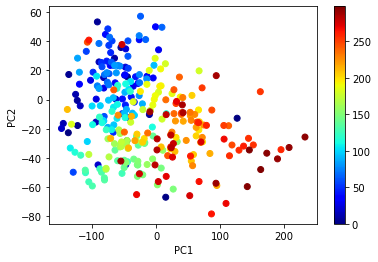

3801.0
(0,)
(1, 3)
(0,)
(1, 3)
3802.0
(0,)
(2, 3)
(0,)
(2, 3)
3501.0
(0,)
(42, 3)
(0,)
(42, 3)
3829.0
(0,)
(2, 3)
(0,)
(2, 3)
3835.0
(0,)
(2, 3)
(0,)
(2, 3)
3592.0
(0,)
(33, 3)
(0,)
(33, 3)
3836.0
(0,)
(33, 3)
(0,)
(33, 3)
3832.0
(0,)
(3, 3)
(0,)
(3, 3)
3723.0
(0,)
(19, 3)
(0,)
(19, 3)
3901.0
(0,)
(22, 3)
(0,)
(22, 3)
3906.0
(0,)
(4, 3)
(0,)
(4, 3)
3944.0
(0,)
(10, 3)
(0,)
(10, 3)
4004.0
(0,)
(58, 3)
(0,)
(58, 3)
4007.0
(0,)
(9, 3)
(0,)
(9, 3)
3933.0
(0,)
(12, 3)
(0,)
(12, 3)
4016.0
(0,)
(11, 3)
(0,)
(11, 3)
4021.0
(0,)
(5, 3)
(0,)
(5, 3)
3158.0
(0,)
(113, 3)
(0,)
(113, 3)
4026.0
(0,)
(6, 3)
(0,)
(6, 3)
4022.0
(0,)
(16, 3)
(0,)
(16, 3)
3735.0
(0,)
(40, 3)
(0,)
(40, 3)
4053.0
(0,)
(2, 3)
(0,)
(2, 3)
4050.0
(0,)
(2, 3)
(0,)
(2, 3)
4005.0
(0,)
(9, 3)
(0,)
(9, 3)
4068.0
(0,)
(7, 3)
(0,)
(7, 3)
4065.0
(0,)
(1, 3)
(0,)
(1, 3)
3867.0
(0,)
(29, 3)
(0,)
(29, 3)
4086.0
(0,)
(22, 3)
(0,)
(22, 3)
4084.0
(0,)
(15, 3)
(0,)
(15, 3)
3917.0
(0,)
(27, 3)
(0,)
(27, 3)
4094.0
(0,)
(17, 3)
(0,)
(17, 3)
410

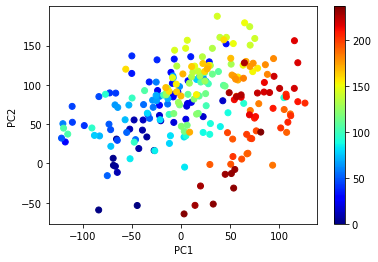

139.0
(0,)
(28, 3)
(0,)
(28, 3)
63.0
(0,)
(77, 3)
(0,)
(77, 3)
147.0
(0,)
(2, 3)
(0,)
(2, 3)
149.0
(0,)
(4, 3)
(0,)
(4, 3)
91.0
(0,)
(88, 3)
(0,)
(88, 3)


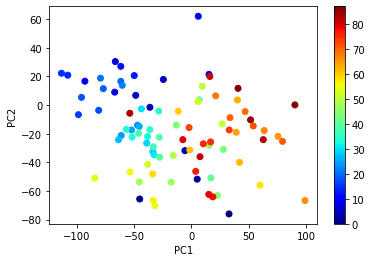

-1.0
176.0
(0,)
(41, 3)
(0,)
(41, 3)
198.0
(0,)
(8, 3)
(0,)
(8, 3)
-1.0
207.0
(0,)
(32, 3)
(0,)
(32, 3)
25.0
(0,)
(199, 3)
(0,)
(199, 3)
219.0
(0,)
(31, 3)
(0,)
(31, 3)
220.0
(0,)
(93, 3)
(0,)
(93, 3)
11.0
(0,)
(221, 3)
(0,)
(221, 3)
238.0
(0,)
(17, 3)
(0,)
(17, 3)
239.0
(0,)
(85, 3)
(0,)
(85, 3)
43.0
(0,)
(268, 3)
(0,)
(268, 3)
323.0
(0,)
(6, 3)
(0,)
(6, 3)
322.0
(0,)
(11, 3)
(0,)
(11, 3)
279.0
(0,)
(33, 3)
(0,)
(33, 3)
326.0
(0,)
(1, 3)
(0,)
(1, 3)
325.0
(0,)
(2, 3)
(0,)
(2, 3)
216.0
(0,)
(93, 3)
(0,)
(93, 3)
364.0
(0,)
(1, 3)
(0,)
(1, 3)
365.0
(0,)
(1, 3)
(0,)
(1, 3)
389.0
(0,)
(11, 3)
(0,)
(11, 3)
405.0
(0,)
(51, 3)
(0,)
(51, 3)
403.0
(0,)
(1, 3)
(0,)
(1, 3)
381.0
(0,)
(17, 3)
(0,)
(17, 3)
414.0
(0,)
(6, 3)
(0,)
(6, 3)
419.0
(0,)
(13, 3)
(0,)
(13, 3)
287.0
(0,)
(81, 3)
(0,)
(81, 3)
421.0
(0,)
(2, 3)
(0,)
(2, 3)
420.0
(0,)
(14, 3)
(0,)
(14, 3)
160.0
(0,)
(211, 3)
(0,)
(211, 3)


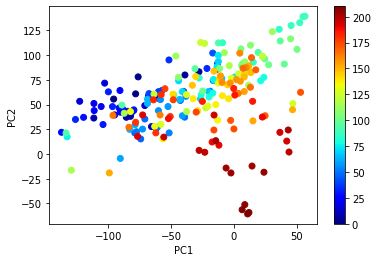

465.0
(0,)
(22, 3)
(0,)
(22, 3)
464.0
(0,)
(3, 3)
(0,)
(3, 3)
141.0
(0,)
(238, 3)
(0,)
(238, 3)


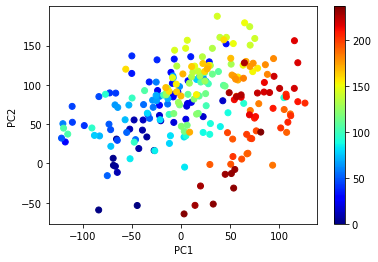

476.0
(0,)
(5, 3)
(0,)
(5, 3)
478.0
(0,)
(104, 3)
(0,)
(104, 3)
379.0
(0,)
(71, 3)
(0,)
(71, 3)
492.0
(0,)
(495, 3)
(0,)
(495, 3)
493.0
(0,)
(5, 3)
(0,)
(5, 3)
430.0
(0,)
(49, 3)
(0,)
(49, 3)
523.0
(0,)
(38, 3)
(0,)
(38, 3)
524.0
(0,)
(7, 3)
(0,)
(7, 3)
487.0
(0,)
(22, 3)
(0,)
(22, 3)
532.0
(0,)
(2, 3)
(0,)
(2, 3)
533.0
(0,)
(3, 3)
(0,)
(3, 3)
501.0
(0,)
(24, 3)
(0,)
(24, 3)
560.0
(0,)
(3, 3)
(0,)
(3, 3)
564.0
(0,)
(3, 3)
(0,)
(3, 3)
687.0
(0,)
(3, 3)
(0,)
(3, 3)
688.0
(0,)
(15, 3)
(0,)
(15, 3)
690.0
(0,)
(6, 3)
(0,)
(6, 3)
640.0
(0,)
(35, 3)
(0,)
(35, 3)
713.0
(0,)
(126, 3)
(0,)
(126, 3)


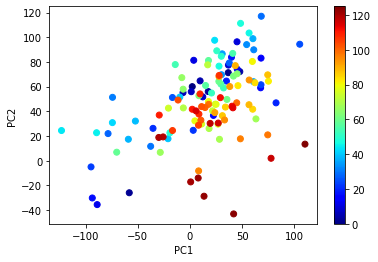

712.0
(0,)
(42, 3)
(0,)
(42, 3)
691.0
(0,)
(8, 3)
(0,)
(8, 3)
716.0
(0,)
(2, 3)
(0,)
(2, 3)
717.0
(0,)
(9, 3)
(0,)
(9, 3)
703.0
(0,)
(7, 3)
(0,)
(7, 3)
722.0
(0,)
(10, 3)
(0,)
(10, 3)
721.0
(0,)
(11, 3)
(0,)
(11, 3)
649.0
(0,)
(43, 3)
(0,)
(43, 3)
743.0
(0,)
(34, 3)
(0,)
(34, 3)
741.0
(0,)
(177, 3)
(0,)
(177, 3)
549.0
(0,)
(158, 3)
(0,)
(158, 3)
856.0
(0,)
(372, 3)
(0,)
(372, 3)


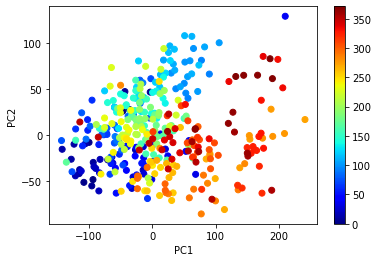

855.0
(0,)
(320, 3)
(0,)
(320, 3)


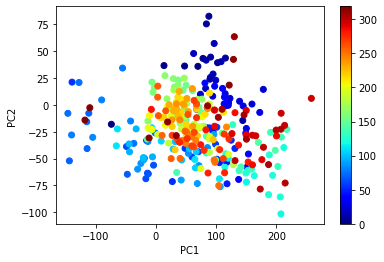

148.0
(0,)
(426, 3)
(0,)
(426, 3)
889.0
(0,)
(8, 3)
(0,)
(8, 3)
887.0
(0,)
(31, 3)
(0,)
(31, 3)
777.0
(0,)
(59, 3)
(0,)
(59, 3)
912.0
(0,)
(31, 3)
(0,)
(31, 3)
909.0
(0,)
(162, 3)
(0,)
(162, 3)
667.0
(0,)
(127, 3)
(0,)
(127, 3)
913.0
(0,)
(29, 3)
(0,)
(29, 3)
914.0
(0,)
(8, 3)
(0,)
(8, 3)
555.0
(0,)
(189, 3)
(0,)
(189, 3)
947.0
(0,)
(78, 3)
(0,)
(78, 3)
948.0
(0,)
(96, 3)
(0,)
(96, 3)
925.0
(0,)
(11, 3)
(0,)
(11, 3)
951.0
(0,)
(3, 3)
(0,)
(3, 3)
952.0
(0,)
(8, 3)
(0,)
(8, 3)
874.0
(0,)
(44, 3)
(0,)
(44, 3)
958.0
(0,)
(3, 3)
(0,)
(3, 3)
957.0
(0,)
(54, 3)
(0,)
(54, 3)
958.0
(0,)
(3, 3)
(0,)
(3, 3)
964.0
(0,)
(1, 3)
(0,)
(1, 3)
961.0
(0,)
(4, 3)
(0,)
(4, 3)
789.0
(0,)
(81, 3)
(0,)
(81, 3)
974.0
(0,)
(2, 3)
(0,)
(2, 3)
972.0
(0,)
(5, 3)
(0,)
(5, 3)
974.0
(0,)
(2, 3)
(0,)
(2, 3)
981.0
(0,)
(1, 3)
(0,)
(1, 3)
984.0
(0,)
(4, 3)
(0,)
(4, 3)
713.0
(0,)
(126, 3)
(0,)
(126, 3)


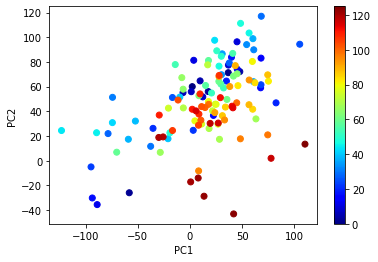

993.0
(0,)
(4, 3)
(0,)
(4, 3)
992.0
(0,)
(41, 3)
(0,)
(41, 3)
785.0
(0,)
(109, 3)
(0,)
(109, 3)
1028.0
(0,)
(3, 3)
(0,)
(3, 3)
1025.0
(0,)
(4, 3)
(0,)
(4, 3)
1025.0
(0,)
(4, 3)
(0,)
(4, 3)
1041.0
(0,)
(8, 3)
(0,)
(8, 3)
1044.0
(0,)
(113, 3)
(0,)
(113, 3)


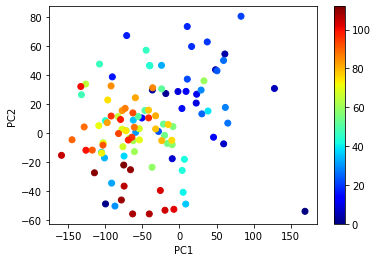

1048.0
(0,)
(5, 3)
(0,)
(5, 3)
1069.0
(0,)
(6, 3)
(0,)
(6, 3)
1068.0
(0,)
(1, 3)
(0,)
(1, 3)
1075.0
(0,)
(13, 3)
(0,)
(13, 3)
1126.0
(0,)
(2, 3)
(0,)
(2, 3)
1125.0
(0,)
(1, 3)
(0,)
(1, 3)
894.0
(0,)
(136, 3)
(0,)
(136, 3)
1250.0
(0,)
(3, 3)
(0,)
(3, 3)
1252.0
(0,)
(4, 3)
(0,)
(4, 3)
919.0
(0,)
(122, 3)
(0,)
(122, 3)
1268.0
(0,)
(1, 3)
(0,)
(1, 3)
1266.0
(0,)
(16, 3)
(0,)
(16, 3)
1247.0
(0,)
(14, 3)
(0,)
(14, 3)
1299.0
(0,)
(18, 3)
(0,)
(18, 3)
1293.0
(0,)
(69, 3)
(0,)
(69, 3)
1002.0
(0,)
(101, 3)
(0,)
(101, 3)
1292.0
(0,)
(8, 3)
(0,)
(8, 3)
1297.0
(0,)
(14, 3)
(0,)
(14, 3)
1295.0
(0,)
(10, 3)
(0,)
(10, 3)
1325.0
(0,)
(2, 3)
(0,)
(2, 3)
1324.0
(0,)
(1, 3)
(0,)
(1, 3)
1366.0
(0,)
(2, 3)
(0,)
(2, 3)
1375.0
(0,)
(1, 3)
(0,)
(1, 3)
1378.0
(0,)
(3, 3)
(0,)
(3, 3)
1337.0
(0,)
(16, 3)
(0,)
(16, 3)
1389.0
(0,)
(9, 3)
(0,)
(9, 3)
1393.0
(0,)
(4, 3)
(0,)
(4, 3)
1502.0
(0,)
(17, 3)
(0,)
(17, 3)
1562.0
(0,)
(22, 3)
(0,)
(22, 3)
1560.0
(0,)
(17, 3)
(0,)
(17, 3)
1286.0
(0,)
(108, 3)
(0,)
(108, 3)
163

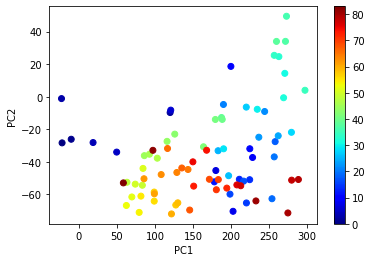

1632.0
(0,)
(12, 3)
(0,)
(12, 3)
1672.0
(0,)
(36, 3)
(0,)
(36, 3)
1671.0
(0,)
(21, 3)
(0,)
(21, 3)
1330.0
(0,)
(118, 3)
(0,)
(118, 3)
1690.0
(0,)
(24, 3)
(0,)
(24, 3)
1691.0
(0,)
(16, 3)
(0,)
(16, 3)
1801.0
(0,)
(8, 3)
(0,)
(8, 3)
1823.0
(0,)
(5, 3)
(0,)
(5, 3)
1828.0
(0,)
(59, 3)
(0,)
(59, 3)
1376.0
(0,)
(152, 3)
(0,)
(152, 3)
1833.0
(0,)
(32, 3)
(0,)
(32, 3)
1832.0
(0,)
(18, 3)
(0,)
(18, 3)
1834.0
(0,)
(5, 3)
(0,)
(5, 3)
1861.0
(0,)
(3, 3)
(0,)
(3, 3)
1860.0
(0,)
(58, 3)
(0,)
(58, 3)
1849.0
(0,)
(7, 3)
(0,)
(7, 3)
1877.0
(0,)
(18, 3)
(0,)
(18, 3)
1876.0
(0,)
(9, 3)
(0,)
(9, 3)
856.0
(0,)
(372, 3)
(0,)
(372, 3)


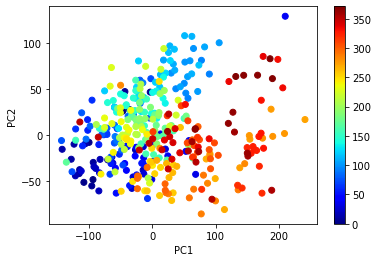

1879.0
(0,)
(3, 3)
(0,)
(3, 3)
1883.0
(0,)
(45, 3)
(0,)
(45, 3)
1909.0
(0,)
(3, 3)
(0,)
(3, 3)
1919.0
(0,)
(1, 3)
(0,)
(1, 3)
1923.0
(0,)
(21, 3)
(0,)
(21, 3)
1482.0
(0,)
(120, 3)
(0,)
(120, 3)
1926.0
(0,)
(46, 3)
(0,)
(46, 3)
1924.0
(0,)
(11, 3)
(0,)
(11, 3)
1913.0
(0,)
(11, 3)
(0,)
(11, 3)
1958.0
(0,)
(212, 3)
(0,)
(212, 3)
1959.0
(0,)
(30, 3)
(0,)
(30, 3)
1761.0
(0,)
(63, 3)
(0,)
(63, 3)
1968.0
(0,)
(3, 3)
(0,)
(3, 3)
1970.0
(0,)
(13, 3)
(0,)
(13, 3)
1923.0
(0,)
(21, 3)
(0,)
(21, 3)
2001.0
(0,)
(1, 3)
(0,)
(1, 3)
2003.0
(0,)
(3, 3)
(0,)
(3, 3)
1982.0
(0,)
(10, 3)
(0,)
(10, 3)
2012.0
(0,)
(2, 3)
(0,)
(2, 3)
2011.0
(0,)
(49, 3)
(0,)
(49, 3)
2003.0
(0,)
(3, 3)
(0,)
(3, 3)
2021.0
(0,)
(22, 3)
(0,)
(22, 3)
2019.0
(0,)
(36, 3)
(0,)
(36, 3)
1962.0
(0,)
(16, 3)
(0,)
(16, 3)
2040.0
(0,)
(6, 3)
(0,)
(6, 3)
2035.0
(0,)
(8, 3)
(0,)
(8, 3)
1640.0
(0,)
(133, 3)
(0,)
(133, 3)
2085.0
(0,)
(2, 3)
(0,)
(2, 3)
2086.0
(0,)
(28, 3)
(0,)
(28, 3)
776.0
(0,)
(429, 3)
(0,)
(429, 3)
2094.0
(0,)
(186, 3)
(0,)

KeyboardInterrupt: 

In [65]:
feature_list=['mean_intensity','std_intensity','intensity_range','haralick','norm_haralick']
fluor_name1='vimentin'
fluor_feature_name1=[fluor_name1+'_haralick']
pc_num1=6

fluor_name2='pcna'
fluor_feature_name2=[fluor_name2+'_haralick']
pc_num2=4

#----------collect intact cell cycle traj-------------------------

all_traj_cords=np.array([])


for posi in range(1,posi_end+1):
    print(posi)
    dir_path=output_path+str(posi)+'/'


    
    with open (cells_path+'fluor_cells_'+str(posi), 'rb') as fp:
        cells = pickle.load(fp)
        
    df=pd.read_csv(dir_path+'Per_Object_relink_'+str(posi)+'.csv')
    am_record=pd.read_csv(dir_path+'am_record_'+str(posi)+'.csv')
    traj_df=pd.read_csv(dir_path+'traj_object_num_'+str(posi)+'.csv')
    mitosis_df=pd.read_csv(dir_path+'mitosis_record_'+str(posi)+'.csv')
    
    time_span=max(df['ImageNumber'])
    
    traj_record=pd.DataFrame(traj_df.loc[:,'1':str(time_span)])
    traj_record=traj_record.values

    traj_quan,traj_len=traj_record.shape[0],traj_record.shape[1]
    #---------------------plot all mitosis traj---------------------
    for index, row in mitosis_df.iterrows():
        mother_label=row['mother_traj_label']
        sis1_label=row['sis1_traj_label']
        sis2_label=row['sis2_traj_label']
        
        for traj_label in [mother_label,sis1_label,sis2_label]:
            print(traj_label)
            if traj_label!=-1:
                if traj_label==mother_label:
#                     traj_contour,traj_cord,traj_seri=generate_single_cell_traj(traj_label,df,cells,traj_df)

                    traj_feature,traj_contour,traj_cord,traj_seri,traj_am_flag,traj_fluor_feature_values1,\
                    traj_fluor_pca_cord1=generate_single_cell_traj\
                    (traj_label,df,cells,traj_df,fluor_name1,fluor_feature_name1,pc_num1)
    
    
                    traj_feature,traj_contour,traj_cord,traj_seri,traj_am_flag,traj_fluor_feature_values2,\
                    traj_fluor_pca_cord2=generate_single_cell_traj\
                    (traj_label,df,cells,traj_df,fluor_name2,fluor_feature_name2,pc_num2)

                    traj_start_am_flag=judge_traj_am(df,am_record,traj_seri,judge_later=True,t_range=am_range)
                    traj_ict_flag=judge_ict(mitosis_df,traj_label)
#                     print('mother',mother_label,len(traj_cord),traj_start_am_flag)
                    
                    if len(traj_cord)>traj_len_thres and (traj_start_am_flag==2 or traj_ict_flag==1):
                        traj_ict=fluor_single_cell_traj(traj_seri,traj_contour)
                        traj_ict.set_traj_cord(traj_cord)
                        traj_ict.set_traj_fluor_features(fluor_name1,feature_list,traj_fluor_feature_values1)
                        traj_ict.set_traj_fluor_pca_cord(fluor_feature_name1[0],traj_fluor_pca_cord1)
                        traj_ict.set_traj_fluor_features(fluor_name2,feature_list,traj_fluor_feature_values2)
                        traj_ict.set_traj_fluor_pca_cord(fluor_feature_name2[0],traj_fluor_pca_cord2)
                        
                        
                        dot_color=np.arange(traj_cord.shape[0])
                        cm=plt.cm.get_cmap('jet')
                        sc=plt.scatter(traj_cord[:,0],traj_cord[:,1],c=dot_color,cmap=cm)
                        plt.xlabel('PC1')
                        plt.ylabel('PC2')
                        plt.colorbar(sc)
                        plt.show()
#                         if len(traj_nuc_intens)>0:
#                             traj_ict.set_traj_nuc_intensity(traj_nuc_intens)

                        with open(ict_path+'ict_xy'+str(posi)+'_'+str(traj_label), 'wb') as fp:
                            pickle.dump(traj_ict, fp)
                
                else:
                    traj_feature,traj_contour,traj_cord,traj_seri,traj_am_flag,traj_fluor_feature_values1,\
                    traj_fluor_pca_cord1=generate_single_cell_traj\
                    (traj_label,df,cells,traj_df,fluor_name1,fluor_feature_name1,pc_num1)
    
    
                    traj_feature,traj_contour,traj_cord,traj_seri,traj_am_flag,traj_fluor_feature_values2,\
                    traj_fluor_pca_cord2=generate_single_cell_traj\
                    (traj_label,df,cells,traj_df,fluor_name2,fluor_feature_name2,pc_num2)
        
                    traj_end_am_flag=judge_traj_am(df,am_record,traj_seri,judge_later=False,t_range=am_range)
                    traj_ict_flag=judge_ict(mitosis_df,traj_label)
#                     print('sister',traj_label,len(traj_cord),traj_start_am_flag)
                    if len(traj_cord)>traj_len_thres and (traj_end_am_flag==2 or traj_ict_flag==1):
                        traj_ict=fluor_single_cell_traj(traj_seri,traj_contour)
                        traj_ict.set_traj_cord(traj_cord)
                        traj_ict.set_traj_fluor_features(fluor_name1,feature_list,traj_fluor_feature_values1)
                        traj_ict.set_traj_fluor_pca_cord(fluor_feature_name1[0],traj_fluor_pca_cord1)
                        traj_ict.set_traj_fluor_features(fluor_name2,feature_list,traj_fluor_feature_values2)
                        traj_ict.set_traj_fluor_pca_cord(fluor_feature_name2[0],traj_fluor_pca_cord2)
                        
                        dot_color=np.arange(traj_cord.shape[0])
                        cm=plt.cm.get_cmap('jet')
                        sc=plt.scatter(traj_cord[:,0],traj_cord[:,1],c=dot_color,cmap=cm)
                        plt.xlabel('PC1')
                        plt.ylabel('PC2')
                        plt.colorbar(sc)
                        plt.show()
#                         if len(traj_nuc_intens)>0:
#                             traj_ict.set_traj_nuc_intensity(traj_nuc_intens)

                        with open(ict_path+'ict_xy'+str(posi)+'_'+str(traj_label), 'wb') as fp:
                            pickle.dump(traj_ict, fp)
                       


In [ ]:
sister_ict_record = pd.DataFrame(columns=['posi','sis1_traj_label','sis2_traj_label'])
parent_ict_record = pd.DataFrame(columns=['posi','mother_traj_label','daughter_traj_label'])
family_ict_record = pd.DataFrame(columns=['posi','mother_traj_label','sis1_traj_label','sis2_traj_label'])
#----------collect family and sister intact cell cycle traj-------------------------

sister_count=0
parent_count=0
family_count=0

for posi in range(1,posi_end+1):   
    dir_path=output_path+str(posi)+'/'
    print(posi)
    
    with open (cells_path+'cells_'+str(posi), 'rb') as fp:
        cells = pickle.load(fp)
        
    df=pd.read_csv(dir_path+'Per_Object_relink_'+str(posi)+'.csv')
    am_record=pd.read_csv(dir_path+'am_record_'+str(posi)+'.csv')
    traj_df=pd.read_csv(dir_path+'traj_object_num_'+str(posi)+'.csv')
    mitosis_df=pd.read_csv(dir_path+'mitosis_record_'+str(posi)+'.csv')
    
    time_span=max(df['ImageNumber'])
    
#     df=pd.read_csv(dir_path+'Per_Object_relink.csv')
#     am_record=pd.read_csv(dir_path+'am_record.csv')
#     traj_df=pd.read_csv(dir_path+'traj_object_num.csv')
#     mitosis_df=pd.read_csv(dir_path+'mitosis_record.csv')
    
    traj_record=pd.DataFrame(traj_df.loc[:,'1':str(time_span)])
    traj_record=traj_record.values

    traj_quan,traj_len=traj_record.shape[0],traj_record.shape[1]
    #---------------------plot all mitosis traj---------------------
    for index, row in mitosis_df.iterrows():
        mother_label=row['mother_traj_label']
        sis1_label=row['sis1_traj_label']
        sis2_label=row['sis2_traj_label']
        
        mother_flag=0
        sis1_flag=0
        sis2_flag=0
        


        
        for traj_label in [mother_label,sis1_label,sis2_label]:
            print(traj_label)
            if traj_label!=-1:
                if traj_label==mother_label:
                    mother_contour,mother_cord,mother_seri=generate_single_cell_traj(traj_label,df,cells,traj_df)
                    mother_start_am_flag=judge_traj_am(df,am_record,mother_seri,judge_later=True,t_range=am_range)
                    traj_ict_flag=judge_ict(mitosis_df,traj_label)
                    if len(mother_cord)>traj_len_thres and (mother_start_am_flag==2 or traj_ict_flag==1):
                        mother_flag+=1
                        mother_ict=single_cell_traj(mother_seri,mother_contour)
                        mother_ict.set_traj_cord(mother_cord)
#                         if len(mother_nuc_intens)>0:
#                             mother_ict.set_traj_nuc_intensity(mother_nuc_intens)
                        with open(ict_path+'ict_xy'+str(posi)+'_'+str(traj_label), 'wb') as fp:
                            pickle.dump(mother_ict, fp)
                if traj_label==sis1_label:
                    sis1_contour,sis1_cord,sis1_seri=generate_single_cell_traj(traj_label,df,cells,traj_df)
                    sis1_end_am_flag=judge_traj_am(df,am_record,sis1_seri,judge_later=False,t_range=am_range)
                    traj_ict_flag=judge_ict(mitosis_df,traj_label)
                    if len(sis1_cord)>traj_len_thres and (sis1_end_am_flag==2 or traj_ict_flag==1):
                        sis1_flag+=1
                        sis1_ict=single_cell_traj(sis1_seri,sis1_contour)
                        sis1_ict.set_traj_cord(sis1_cord)
#                         if len(sis1_nuc_intens)>0:
#                             sis1_ict.set_traj_nuc_intensity(sis1_nuc_intens)
                        with open(ict_path+'ict_xy'+str(posi)+'_'+str(traj_label), 'wb') as fp:
                            pickle.dump(sis1_ict, fp)
                if traj_label==sis2_label:
                    sis2_contour,sis2_cord,sis2_seri=generate_single_cell_traj(traj_label,df,cells,traj_df)
                    sis2_end_am_flag=judge_traj_am(df,am_record,sis2_seri,judge_later=False,t_range=am_range)
                    traj_ict_flag=judge_ict(mitosis_df,traj_label)
                    if len(sis2_cord)>traj_len_thres and (sis2_end_am_flag==2 or traj_ict_flag==1):
                        sis2_flag+=1
                        sis2_ict=single_cell_traj(sis2_seri,sis2_contour)
                        sis2_ict.set_traj_cord(sis2_cord)
#                         if len(sis2_nuc_intens)>0:
#                             sis2_ict.set_traj_nuc_intensity(sis2_nuc_intens)
                        with open(ict_path+'ict_xy'+str(posi)+'_'+str(traj_label), 'wb') as fp:
                            pickle.dump(sis2_ict, fp)
                
        if mother_flag==1 and (sis1_flag+sis2_flag)==1:
            print('parent',mother_label)
            parent_count+=1
      

            if sis1_flag==1:
                print(sis1_label)
                parent_ict_record.loc[parent_count]=[posi,mother_label,sis1_label]

            if sis2_flag==1:
                print(sis2_label)
                parent_ict_record.loc[parent_count]=[posi,mother_label,sis2_label]

        if mother_flag==1 and sis1_flag==1 and sis2_flag==1:
            print('family',mother_label,sis1_label,sis2_label)
            family_count+=1
            family_ict_record.loc[family_count]=[posi,mother_label,sis1_label,sis2_label]
            
            

            
        if sis1_flag==1 and sis2_flag==1:
            print('sister',sis1_label,sis2_label)
            sister_count+=1
            sister_ict_record.loc[sister_count]=[posi,sis1_label,sis2_label]

        
            
sister_ict_record.to_csv(main_path+'sister_ict_record.csv', index=False,encoding='utf-8')  
family_ict_record.to_csv(main_path+'family_ict_record.csv', index=False,encoding='utf-8') 
parent_ict_record.to_csv(main_path+'parent_ict_record.csv', index=False,encoding='utf-8')  
            
            
                

#                         sio.savemat(main_path+'traj_pca_cord_'+str(traj_label)+'.mat', {'arr': traj_cord.T})
#                         sio.savemat(main_path+'traj_contour_'+str(traj_label)+'.mat', {'arr': traj_contour.T})
#                         ict=single_cell_traj(traj_contour)
#                         ict.set_traj_cord(traj_cord)
#                         if len(traj_nuc_intens)>0:
#                             ict.set_traj_nuc_intensity(traj_nuc_intens)
#                         with open(ict_path+'ict_xy'+str(posi)+'_'+str(traj_label), 'wb') as fp:
#                             pickle.dump(ict, fp)
                       

In [ ]:
#----------collect single consecutive traj-------------------------
for posi in range(1,posi_end+1):   
    dir_path=output_path+str(posi)+'/'

    df=pd.read_csv(dir_path+'Per_Object_relink_'+str(posi)+'.csv')
    am_record=pd.read_csv(dir_path+'am_record_'+str(posi)+'.csv')
    traj_df=pd.read_csv(dir_path+'traj_object_num_'+str(posi)+'.csv')
    
#     df=pd.read_csv(dir_path+'Per_Object_relink.csv')
#     am_record=pd.read_csv(dir_path+'am_record.csv')
#     traj_df=pd.read_csv(dir_path+'traj_object_num.csv')
    
    with open (cells_path+'cells_'+str(posi), 'rb') as fp:
        cells = pickle.load(fp)

    traj_record=pd.DataFrame(traj_df.loc[:,'1':str(time_span)])
    traj_record=traj_record.values

    traj_quan,traj_len=traj_record.shape[0],traj_record.shape[1]
    #---------------------plot all mitosis traj---------------------

        
    for traj_label in range(1,traj_quan+1):

        cur_traj=traj_record[traj_label-1,:]

        cons_ind_arrs=consecutive_arrs(np.where(cur_traj!=-1)[0])
        for i in range(len(cons_ind_arrs)):
            if cons_ind_arrs[i].shape[0]>50:
                traj_contour=[]
                traj_cord=[]
                traj_t=[]
                traj_seri=[]
                
                
                
                for j in range(cons_ind_arrs[i].shape[0]):
                    img_num=int(cons_ind_arrs[i][j]+1)
                    obj_num=cur_traj[cons_ind_arrs[i]][j]

                    ind=df.loc[(df['ImageNumber']==img_num)&(df['ObjectNumber']==obj_num)].index.tolist()[0]
                    if hasattr(cells[ind],'pca_cord') and hasattr(cells[ind],'cell_contour'):
                        cell_posi=cells[ind].pca_cord
                        
                        traj_contour.append(cells[ind].cell_contour.points.flatten())
                        traj_cord.append(cell_posi)
                        traj_seri.append([img_num,obj_num])
                 
                
                traj_contour=np.asarray(traj_contour)
                traj_cord=np.asarray(traj_cord)
                traj_seri=np.asarray(traj_seri)

                
                
                sct=single_cell_traj(traj_seri,traj_contour)
                sct.set_traj_cord(traj_cord)
                with open(sct_path+'sct_xy'+str(posi)+'_'+str(traj_label)+'_'+str(i), 'wb') as fp:
                        pickle.dump(sct, fp)

In [ ]:
#----------collect intact mother and partial daughter traj-------------------------


for posi in range(1,posi_end+1):
    print(posi)
    dir_path=output_path+str(posi)+'/'
    

    
    with open (cells_path+'cells_'+str(posi), 'rb') as fp:
        cells = pickle.load(fp)
        
    df=pd.read_csv(dir_path+'Per_Object_relink_'+str(posi)+'.csv')
    am_record=pd.read_csv(dir_path+'am_record_'+str(posi)+'.csv')
    traj_df=pd.read_csv(dir_path+'traj_object_num_'+str(posi)+'.csv')
    mitosis_df=pd.read_csv(dir_path+'mitosis_record_'+str(posi)+'.csv')
    
    candi_ict=[]

    #---------------------plot all mitosis traj---------------------
    for index, row in mitosis_df.iterrows():
        mother_label=row['mother_traj_label']
        sis1_label=row['sis1_traj_label']
        sis2_label=row['sis2_traj_label']
        
        candi_ict.append(mother_label)
        candi_ict.append(sis1_label)
        candi_ict.append(sis2_label)
    print(candi_ict)
  
    for traj_label in candi_ict:


        mother_flag=0
        sis1_flag=0
        sis2_flag=0
        
        if traj_label!=-1 and (mitosis_df['mother_traj_label']==traj_label).any():
            print(traj_label)
        
            if ((mitosis_df['sis1_traj_label']==traj_label).any() or (mitosis_df['sis2_traj_label']==traj_label).any()):                            
                traj_contour,traj_cord,traj_nuc_intens,traj_seri,traj_t=generate_single_cell_traj(traj_label,df,cells,traj_df)
                if len(traj_cord)>traj_len_thres:
                    mother_flag=1
                    traj_ict=single_cell_traj(traj_seri,traj_contour)
                    traj_ict.set_traj_cord(traj_cord)
                    if len(traj_nuc_intens)>0:
                        traj_ict.set_traj_nuc_intensity(traj_nuc_intens)
            if not ((mitosis_df['sis1_traj_label']==traj_label).any() or (mitosis_df['sis2_traj_label']==traj_label).any()):
                traj_contour,traj_cord,traj_nuc_intens,traj_seri,traj_t=generate_single_cell_traj(traj_label,df,cells,traj_df)
                traj_start_am_flag=judge_traj_am(df,am_record,traj_seri,judge_later=True,t_range=am_range)
                if len(traj_cord)>traj_len_thres and traj_start_am_flag==2:
                    mother_flag=1
                    traj_ict=single_cell_traj(traj_seri,traj_contour)
                    traj_ict.set_traj_cord(traj_cord)
                    if len(traj_nuc_intens)>0:
                        traj_ict.set_traj_nuc_intensity(traj_nuc_intens)


            sis1_label=mitosis_df.loc[mitosis_df['mother_traj_label']==traj_label,'sis1_traj_label'].values[0]
            print(sis1_label)
            if sis1_label!=-1:
                sis1_contour,sis1_cord,sis1_nuc_intens,sis1_seri,sis1_t=generate_single_cell_traj(sis1_label,df,cells,traj_df)
                if len(sis1_cord)>part_traj_len_thres:
                    sis1_flag+=1
                    sis1_ict=single_cell_traj(sis1_seri,sis1_contour)
                    sis1_ict.set_traj_cord(sis1_cord)
                    if len(sis1_nuc_intens)>0:
                        sis1_ict.set_traj_nuc_intensity(sis1_nuc_intens)

            sis2_label=mitosis_df.loc[mitosis_df['mother_traj_label']==traj_label,'sis2_traj_label'].values[0]
            print(sis2_label)
            if sis2_label!=-1:
                sis2_contour,sis2_cord,sis2_nuc_intens,sis2_seri,sis2_t=generate_single_cell_traj(sis2_label,df,cells,traj_df)
                if len(sis2_cord)>part_traj_len_thres:
                    sis2_flag+=1
                    sis2_ict=single_cell_traj(sis2_seri,sis2_contour)
                    sis2_ict.set_traj_cord(sis2_cord)
                    if len(sis2_nuc_intens)>0:
                        sis2_ict.set_traj_nuc_intensity(sis2_nuc_intens)






            if mother_flag==1 and sis1_flag==1:
                mother_sis1_seri=np.concatenate((traj_seri,sis1_seri))
                divide_points=np.array([traj_seri[-1][0]])
                mother_sis1_contour=np.concatenate((traj_contour,sis1_contour))
                mother_sis1_cord=np.concatenate((traj_cord,sis1_cord))

                dot_color=np.arange(mother_sis1_cord.shape[0])
                cm=plt.cm.get_cmap('jet')
                sc=plt.scatter(mother_sis1_cord[:,0], mother_sis1_cord[:,1],c=dot_color,cmap=cm)
                plt.xlabel('PC1')
                plt.ylabel('PC2')
                plt.colorbar(sc)
                plt.show()

                mother_sis1_ict=single_cell_traj(mother_sis1_seri,mother_sis1_contour)
                mother_sis1_ict.set_traj_cord(mother_sis1_cord)
                mother_sis1_ict.set_traj_divide_points(divide_points)
                with open(impd_path+'impd_xy'+str(posi)+'_'+str(traj_label)+'_sis1', 'wb') as fp:
                    pickle.dump(mother_sis1_ict, fp)

                sio.savemat(impd_path+'traj_cord_xy'+str(posi)+'_'+str(traj_label)+'_sis1.mat', {'arr': mother_sis1_cord.T})
                sio.savemat(impd_path+'traj_contour_xy'+str(posi)+'_'+str(traj_label)+'_sis1.mat', {'arr': mother_sis1_contour.T})

            if mother_flag==1 and sis2_flag==1:    

                mother_sis2_seri=np.concatenate((traj_seri,sis2_seri))
                divide_points=np.array([traj_seri[-1][0]])
                mother_sis2_contour=np.concatenate((traj_contour,sis2_contour))
                mother_sis2_cord=np.concatenate((traj_cord,sis2_cord))

                dot_color=np.arange(mother_sis2_cord.shape[0])
                cm=plt.cm.get_cmap('jet')
                sc=plt.scatter(mother_sis2_cord[:,0], mother_sis2_cord[:,1],c=dot_color,cmap=cm)
                plt.xlabel('PC1')
                plt.ylabel('PC2')
                plt.colorbar(sc)
                plt.show()

                mother_sis2_ict=single_cell_traj(mother_sis2_seri,mother_sis2_contour)
                mother_sis2_ict.set_traj_cord(mother_sis2_cord)
                mother_sis2_ict.set_traj_divide_points(divide_points)
                with open(impd_path+'impd_xy'+str(posi)+'_'+str(traj_label)+'_sis2', 'wb') as fp:
                    pickle.dump(mother_sis2_ict, fp)



                sio.savemat(impd_path+'traj_cord_xy'+str(posi)+'_'+str(traj_label)+'_sis2.mat', {'arr': mother_sis2_cord.T})
                sio.savemat(impd_path+'traj_contour_xy'+str(posi)+'_'+str(traj_label)+'_sis2.mat', {'arr': mother_sis2_contour.T})
            
#             if mother_flag==1 and sis1_flag==1 and sis2_flag==1:
                
#                 plt.scatter(traj_seri[:,0]-traj_seri[0,0],traj_cord[:,0],color='g',label='mother')
#                 plt.scatter(sis1_seri[:,0]-traj_seri[0,0],sis1_cord[:,0],color='r',label='sister1')
#                 plt.scatter(sis2_seri[:,0]-traj_seri[0,0],sis2_cord[:,0],color='k',label='sister2')
#                 plt.xlabel('t')
#                 plt.ylabel('PC1')
#                 plt.legend()
#                 plt.show()
                

In [ ]:
#----------collect partial mother and daughter intact cell cycle traj-------------------------

all_traj_cords=np.array([])


for posi in range(1,posi_end+1):
    print(posi)
    dir_path=output_path+str(posi)+'/'


    
    with open (cells_path+'cells_'+str(posi), 'rb') as fp:
        cells = pickle.load(fp)
        
    df=pd.read_csv(dir_path+'Per_Object_relink_'+str(posi)+'.csv')
    am_record=pd.read_csv(dir_path+'am_record_'+str(posi)+'.csv')
    traj_df=pd.read_csv(dir_path+'traj_object_num_'+str(posi)+'.csv')
    mitosis_df=pd.read_csv(dir_path+'mitosis_record_'+str(posi)+'.csv')

    #---------------------plot all mitosis traj---------------------
    for index, row in mitosis_df.iterrows():
        mother_label=row['mother_traj_label']
        sis1_label=row['sis1_traj_label']
        sis2_label=row['sis2_traj_label']
        mother_flag=0
        sis1_flag=0
        sis2_flag=0
        for traj_label in [mother_label,sis1_label,sis2_label]:
            if traj_label!=-1:
                if traj_label==mother_label:
                    mother_contour,mother_cord,mother_nuc_intens,mother_seri,mother_t=generate_single_cell_traj(traj_label,df,cells,traj_df)
                    if len(mother_cord)>part_traj_len_thres:
                        mother_flag+=1
                        mother_ict=single_cell_traj(mother_seri,mother_contour)
                        mother_ict.set_traj_cord(mother_cord)
                        if len(mother_nuc_intens)>0:
                            mother_ict.set_traj_nuc_intensity(mother_nuc_intens)
                if traj_label==sis1_label:
                    sis1_contour,sis1_cord,sis1_nuc_intens,sis1_seri,sis1_t=generate_single_cell_traj(traj_label,df,cells,traj_df)
                    sis1_end_am_flag=judge_traj_am(df,am_record,sis1_seri,judge_later=False,t_range=am_range)
                    if len(sis1_cord)>traj_len_thres and sis1_end_am_flag==2:
                        sis1_flag+=1
                        sis1_ict=single_cell_traj(sis1_seri,sis1_contour)
                        sis1_ict.set_traj_cord(sis1_cord)
                        if len(sis1_nuc_intens)>0:
                            sis1_ict.set_traj_nuc_intensity(sis1_nuc_intens)
                if traj_label==sis2_label:
                    sis2_contour,sis2_cord,sis2_nuc_intens,sis2_seri,sis2_t=generate_single_cell_traj(traj_label,df,cells,traj_df)
                    sis2_end_am_flag=judge_traj_am(df,am_record,sis2_seri,judge_later=False,t_range=am_range)
                    if len(sis2_cord)>traj_len_thres and sis2_end_am_flag==2:
                        sis2_flag+=1
                        sis2_ict=single_cell_traj(sis2_seri,sis2_contour)
                        sis2_ict.set_traj_cord(sis2_cord)
                        if len(sis2_nuc_intens)>0:
                            sis2_ict.set_traj_nuc_intensity(sis2_nuc_intens)
                
        if mother_flag==1 and sis1_flag==1:
            mother_sis1_seri=np.concatenate((mother_seri,sis1_seri))
            divide_points=np.array([mother_seri[-1][0]])
            mother_sis1_contour=np.concatenate((mother_contour,sis1_contour))
            mother_sis1_cord=np.concatenate((mother_cord,sis1_cord))
            
            mother_sis1_ict=single_cell_traj(mother_sis1_seri,mother_sis1_contour)
            mother_sis1_ict.set_traj_cord(mother_sis1_cord)
            mother_sis1_ict.set_traj_divide_points(divide_points)
            with open(pmid_path+'pmid_xy'+str(posi)+'_'+str(mother_label)+'_sis1', 'wb') as fp:
                pickle.dump(mother_sis1_ict, fp)
                
            sio.savemat(pmid_path+'traj_cord_xy'+str(posi)+'_'+str(mother_label)+'_sis1.mat', {'arr': mother_sis1_cord.T})
            sio.savemat(pmid_path+'traj_contour_xy'+str(posi)+'_'+str(mother_label)+'_sis1.mat', {'arr': mother_sis1_contour.T})
            
        if mother_flag==1 and sis2_flag==1:    
            
            mother_sis2_seri=np.concatenate((mother_seri,sis2_seri))
            divide_points=np.array([mother_seri[-1][0]])
            mother_sis2_contour=np.concatenate((mother_contour,sis2_contour))
            mother_sis2_cord=np.concatenate((mother_cord,sis2_cord))
            
            mother_sis2_ict=single_cell_traj(mother_sis2_seri,mother_sis2_contour)
            mother_sis2_ict.set_traj_cord(mother_sis2_cord)
            mother_sis2_ict.set_traj_divide_points(divide_points)
            with open(pmid_path+'pmid_xy'+str(posi)+'_'+str(mother_label)+'_sis2', 'wb') as fp:
                pickle.dump(mother_sis2_ict, fp)
 

            sio.savemat(pmid_path+'traj_cord_xy'+str(posi)+'_'+str(mother_label)+'_sis2.mat', {'arr': mother_sis2_cord.T})
            sio.savemat(pmid_path+'traj_contour_xy'+str(posi)+'_'+str(mother_label)+'_sis2.mat', {'arr': mother_sis2_contour.T})

#         if mother_flag==1 and sis1_flag==1 and sis2_flag==1:

#             plt.scatter(mother_seri[:,0]-mother_seri[0,0],mother_cord[:,0],color='g',label='mother')
#             plt.scatter(sis1_seri[:,0]-mother_seri[0,0],sis1_cord[:,0],color='r',label='sister1')
#             plt.scatter(sis2_seri[:,0]-mother_seri[0,0],sis2_cord[:,0],color='k',label='sister2')
#             plt.xlabel('t')
#             plt.ylabel('PC1')
#             plt.legend()
#             plt.show()
            
#             plt.scatter(mother_seri[:,0]-mother_seri[0,0],mother_cord[:,1],color='g',label='mother')
#             plt.scatter(sis1_seri[:,0]-mother_seri[0,0],sis1_cord[:,1],color='r',label='sister1')
#             plt.scatter(sis2_seri[:,0]-mother_seri[0,0],sis2_cord[:,1],color='k',label='sister2')
#             plt.xlabel('t')
#             plt.ylabel('PC2')
#             plt.legend()
#             plt.show()
